In [4]:
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import BaseMessage, HumanMessage
from src.agents import create_agent



In [ ]:
thread_config = {"configurable": {"thread_id": "deep-research-thread-11thronee1"}}

query = """
Do a deep research on agentech in oklahoma city. you should use the web. Agentech is a new startup in the Insurance Claims space. You need to find out the following:
this is their url: https://www.agentech.com/
1. Who are the founders of the company?
2. What is the funding status of the company?
3. What are the recent news articles about the company?
4. What are the competitors of the company?
5. What are the recent job postings for the company?
"""

initial_input = {"messages": [HumanMessage(content=query)]}

result = agent.invoke(initial_input, config=thread_config)

In [ ]:
result

In [ ]:
# The final output structure might vary, adjust this key if needed.
if result.get('messages') and isinstance(result['messages'], list) and len(result['messages']) > 1:
        final_report_content = result['messages'][-1].content
        # Assuming the report is in the content of the last message
        print("\n--- FINAL REPORT ---")
        print(final_report_content)
else:
        print("Could not find final report in the result.")
        print(result)



--- FINAL REPORT ---
I'm sorry, but I was unable to find any information on a company called Agentech in Oklahoma City. The URL provided does not lead to a valid website. It's possible that there may be a typo in the name or the company is too new to have an online presence. If you have any additional information, I would be happy to continue the research.


In [2]:
from src.agents.agent import deep_agent


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\pault\anaconda3\envs\app_project\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.sta

In [3]:
import os
from typing import Literal

from tavily import TavilyClient
from src.agents.agent import deep_agent
from typing import Any, Callable, List, Optional, cast, Dict, Literal, Union
import os 
from pydantic import BaseModel, Field
from dotenv import load_dotenv
# It's best practice to initialize the client once and reuse it.
tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

# # Search tool to use to do research
# def internet_search(
#     query: str,
#     max_results: int = 5,
#     topic: Literal["general", "news", "finance"] = "general",
#     include_raw_content: bool = False,
# ):
#     """Run a web search"""
#     search_docs = tavily_client.search(
#         query,
#         max_results=max_results,
#         include_raw_content=include_raw_content,
#         topic=topic,
#     )
#     return search_docs


from langchain_tavily import TavilySearch
from langchain.tools import StructuredTool

# Load environment variables from a .env file for local development.
load_dotenv()

# --- Pydantic Input Schema for Robust Validation ---
class TavilySearchInput(BaseModel):
    """Input schema for the Tavily Search tool."""
    query: str = Field(..., description="The search query to look up.")
    max_results: Optional[int] = Field(
        default=5, description="The maximum number of search results to return."
    )
    search_depth: Optional[Literal["basic", "advanced"]] = Field(
        default="advanced", description="The depth of the search: 'basic' or 'advanced'."
    )
    topic: Optional[Literal["general", "news", "finance"]] = Field(
        default="general", description="The topic for the search."
    )
    include_domains: Optional[List[str]] = Field(
        default=None, description="A list of domains to specifically include in the search."
    )
    exclude_domains: Optional[List[str]] = Field(
        default=None, description="A list of domains to specifically exclude from the search."
    )


class TavilySearchTool:
    """
    A robust, production-ready tool for performing web searches with Tavily.

    This class encapsulates the logic for the search tool, using Pydantic for
    input validation and providing a secure way to handle API keys for both
    local development and production deployment.
    """
    def __init__(self, api_key: Optional[str] = None):
        """
        Initializes the tool and securely configures the API key.
        """
        self.api_key = api_key or os.getenv("TAVILY_API_KEY")
        if not self.api_key:
            raise ValueError(
                "Tavily API key not provided. Please pass it to the constructor "
                "or set the TAVILY_API_KEY environment variable."
            )
        # Instantiate the TavilySearch tool from the correct package once.
        self.tool = TavilySearch(tavily_api_key=self.api_key)


    def run(self, **kwargs) -> List[Dict[str, Any]]:
        """
        Executes the Tavily search with validated input.

        This method is designed to be wrapped by a LangChain StructuredTool.
        It takes keyword arguments that are validated by the Pydantic schema.
        """
        try:
            # Validate the input using the Pydantic model
            validated_args = TavilySearchInput(**kwargs)

            # Convert the Pydantic model to a dictionary for invocation.
            # exclude_none=True ensures we don't pass optional args if they weren't provided.
            invoke_args = validated_args.model_dump(exclude_none=True)

            # Perform the search using the validated arguments
            result = self.tool.invoke(invoke_args)
            return result
        except Exception as e:
            # Return a structured error message if something goes wrong
            return [{"error": f"An error occurred during the search: {e}"}]

# --- Create a default instance and a StructuredTool ---

# 1. Instantiate our production-ready class.
default_tavily_instance = TavilySearchTool()

# 2. Create a StructuredTool from the class method.
internet_search = StructuredTool.from_function(
    name="internet_search",
    func=default_tavily_instance.run,
    description=(
        "A search engine optimized for comprehensive, accurate, and trusted results. "
        "Use this for any general web search, research, or to find current events."
    ),
    args_schema=TavilySearchInput
)


sub_research_prompt = """You are a dedicated researcher. Your job is to conduct research based on the users questions.

Conduct thorough research and then reply to the user with a detailed answer to their question

only your FINAL answer will be passed on to the user. They will have NO knowledge of anything except your final message, so your final report should be your final message!"""

research_sub_agent = {
    "name": "research-agent",
    "description": "Used to research more in depth questions. Only give this researcher one topic at a time. Do not pass multiple sub questions to this researcher. Instead, you should break down a large topic into the necessary components, and then call multiple research agents in parallel, one for each sub question.",
    "prompt": sub_research_prompt,
    "tools": [internet_search],
}

sub_critique_prompt = """You are a dedicated editor. You are being tasked to critique a report.

You can find the report at `final_report.md`.

You can find the question/topic for this report at `question.txt`.

The user may ask for specific areas to critique the report in. Respond to the user with a detailed critique of the report. Things that could be improved.

You can use the search tool to search for information, if that will help you critique the report

Do not write to the `final_report.md` yourself.

Things to check:
- Check that each section is appropriately named
- Check that the report is written as you would find in an essay or a textbook - it should be text heavy, do not let it just be a list of bullet points!
- Check that the report is comprehensive. If any paragraphs or sections are short, or missing important details, point it out.
- Check that the article covers key areas of the industry, ensures overall understanding, and does not omit important parts.
- Check that the article deeply analyzes causes, impacts, and trends, providing valuable insights
- Check that the article closely follows the research topic and directly answers questions
- Check that the article has a clear structure, fluent language, and is easy to understand.
"""

critique_sub_agent = {
    "name": "critique-agent",
    "description": "Used to critique the final report. Give this agent some information about how you want it to critique the report.",
    "prompt": sub_critique_prompt,
}


# Prompt prefix to steer the agent to be an expert researcher
research_instructions = """You are an expert researcher. Your job is to conduct thorough research, and then write a polished report.

The first thing you should do is to write the original user question to `question.txt` so you have a record of it.

Use the research-agent to conduct deep research. It will respond to your questions/topics with a detailed answer.

When you think you enough information to write a final report, write it to `final_report.md`

You can call the critique-agent to get a critique of the final report. After that (if needed) you can do more research and edit the `final_report.md`
You can do this however many times you want until are you satisfied with the result.

Only edit the file once at a time (if you call this tool in parallel, there may be conflicts).

Here are instructions for writing the final report:

<report_instructions>

CRITICAL: Make sure the answer is written in the same language as the human messages! If you make a todo plan - you should note in the plan what language the report should be in so you dont forget!
Note: the language the report should be in is the language the QUESTION is in, not the language/country that the question is ABOUT.

Please create a detailed answer to the overall research brief that:
1. Is well-organized with proper headings (# for title, ## for sections, ### for subsections)
2. Includes specific facts and insights from the research
3. References relevant sources using [Title](URL) format
4. Provides a balanced, thorough analysis. Be as comprehensive as possible, and include all information that is relevant to the overall research question. People are using you for deep research and will expect detailed, comprehensive answers.
5. Includes a "Sources" section at the end with all referenced links

You can structure your report in a number of different ways. Here are some examples:

To answer a question that asks you to compare two things, you might structure your report like this:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

To answer a question that asks you to return a list of things, you might only need a single section which is the entire list.
1/ list of things or table of things
Or, you could choose to make each item in the list a separate section in the report. When asked for lists, you don't need an introduction or conclusion.
1/ item 1
2/ item 2
3/ item 3

To answer a question that asks you to summarize a topic, give a report, or give an overview, you might structure your report like this:
1/ overview of topic
2/ concept 1
3/ concept 2
4/ concept 3
5/ conclusion

If you think you can answer the question with a single section, you can do that too!
1/ answer

REMEMBER: Section is a VERY fluid and loose concept. You can structure your report however you think is best, including in ways that are not listed above!
Make sure that your sections are cohesive, and make sense for the reader.

For each section of the report, do the following:
- Use simple, clear language
- Use ## for section title (Markdown format) for each section of the report
- Do NOT ever refer to yourself as the writer of the report. This should be a professional report without any self-referential language. 
- Do not say what you are doing in the report. Just write the report without any commentary from yourself.
- Each section should be as long as necessary to deeply answer the question with the information you have gathered. It is expected that sections will be fairly long and verbose. You are writing a deep research report, and users will expect a thorough answer.
- Use bullet points to list out information when appropriate, but by default, write in paragraph form.

REMEMBER:
The brief and research may be in English, but you need to translate this information to the right language when writing the final answer.
Make sure the final answer report is in the SAME language as the human messages in the message history.

Format the report in clear markdown with proper structure and include source references where appropriate.

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Each source should be a separate line item in a list, so that in markdown it is rendered as a list.
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
- Citations are extremely important. Make sure to include these, and pay a lot of attention to getting these right. Users will often use these citations to look into more information.
</Citation Rules>
</report_instructions>

You have access to a few tools.

## `internet_search`

Use this to run an internet search for a given query. You can specify the number of results, the topic, and whether raw content should be included.
"""

# Create the agent
agent = deep_agent(
    agent_name="coder",
    agent_type="coder",
    tools=[internet_search],
    prompt_template=research_instructions,
    sub_research_prompt=sub_research_prompt,
    sub_critique_prompt=sub_critique_prompt,
).with_config({"recursion_limit": 1000})

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import BaseMessage, HumanMessage
from langfuse.langchain import CallbackHandler

thread_config = {"configurable": {"thread_id": "deep-research-thread-1011-earth23"},
                 "callbacks": [CallbackHandler()]}

query = """
Do a deep research on agentech in oklahoma city. you should use the web. Agentech is a new startup in the Insurance Claims space. You need to find out the following:
this is their url: https://www.agentech.com/
1. Who are the founders of the company?
2. What is the funding status of the company?
3. What are the recent news articles about the company?
4. What are the competitors of the company?
5. What are the recent job postings for the company?
"""

initial_input = {"messages": [HumanMessage(content=query)]}

output = agent.invoke(initial_input, config=thread_config)

In [15]:
output.get('files')

{'question.txt': 'Do a deep research on Agentech in Oklahoma City. You should use the web. Agentech is a new startup in the Insurance Claims space. You need to find out the following:\nThis is their URL: https://www.agentech.com/\n1. Who are the founders of the company?\n2. What is the funding status of the company?\n3. What are the recent news articles about the company?\n4. What are the competitors of the company?\n5. What are the recent job postings for the company?',
 'final_report.md': "# Deep Research Report: Agentech in Oklahoma City\n\n## Founders of Agentech\nAgentech was co-founded by Alex Pezold and Robin Roberson. Both have significant experience in insurance technology and entrepreneurial leadership. Pezold previously served as CEO and founder of TokenEx (which exited for over $130 million), while Roberson is a veteran in the insurtech sector with multiple startups in her portfolio.[1][2][3][4][5]\n\n## Funding Status\nAgentech recently secured $3 million in seed funding i

In [8]:
print(output['files']['final_report.md'])

# Deep Research Report: Agentech in Oklahoma City

## Founders of Agentech
Agentech was co-founded by Alex Pezold and Robin Roberson. Both have significant experience in insurance technology and entrepreneurial leadership. Pezold previously served as CEO and founder of TokenEx (which exited for over $130 million), while Roberson is a veteran in the insurtech sector with multiple startups in her portfolio.[1][2][3][4][5]

## Funding Status
Agentech recently secured $3 million in seed funding in October 2024. The seed round was completed within 30 days and was mostly backed by Oklahoma-based investors, with participation from venture capital firms like Cortado Ventures. The funding is intended for expanding Agentech’s AI-powered insurance claims platform into new lines including property & casualty, workers' compensation, and travel insurance claims workflows.[2][3][4][5]

## Recent News Articles About Agentech
- **Agentech creates digital workforce for AI insurance claims workflow** – T

In [9]:
print(output['messages'][-1].content)

The research is complete and the final report has been written to final_report.md. Would you like a critique or have any follow-up requests?


> Testing the Planner Node:

In [ ]:
# Core libraries for typing, data structures, and logging
import logging
import json
from typing import TypedDict, Literal, NamedTuple, Any, List, Dict

# Pydantic for data modeling, using v1 for LangChain compatibility
from pydantic.v1 import BaseModel, Field, ValidationError

# Mocking LangChain components
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AIMessage, BaseMessage
# from langchain_core.language_models.fake import FakeChatModel
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from src.llms.llm import get_llm_by_type, get_llm_token_limit_by_type

# Copyright (c) 2025 Bytedance Ltd. and/or its affiliates
# SPDX-License-Identifier: MIT

import json
import logging
import os
from typing import Annotated, Literal
from pydantic import ValidationError
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_mcp_adapters.client import MultiServerMCPClient
from trustcall import create_extractor
from src.prompts.template import get_prompt_template
from langgraph.types import Command, interrupt
from langgraph.graph import END, START, StateGraph
from functools import partial

from src.agents import create_agent, deep_agent
# from src.agents.deep_agents import DeepAgentState, create_deep_agent, async_create_deep_agent
from src.config.agents import AGENT_LLM_MAP
from src.graph.types import State
from src.config.configuration import Configuration
from src.llms.llm import get_llm_by_type, get_llm_token_limit_by_type
from src.prompts.planner_model import Plan
from src.prompts.template import apply_prompt_template
from src.prompts.planner_model import StepType
from src.tools import (
    crawl_tool,
    get_retriever_tool,
    get_web_search_tool,
    python_repl_tool,
)
from src.tools.search import LoggedTavilySearch
from src.utils.json_utils import repair_json_output
from src.utils.context_manager import ContextManager

logger = logging.getLogger(__name__)
# --- Basic logging setup to see node output ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
def build_plan_with_trustcall(messages: list[dict], config: RunnableConfig, existing: Plan | None = None) -> Plan:
    configurable = Configuration.from_runnable_config(config)
    logger.info("Building plan with TrustCall")
    
    if configurable.enable_deep_thinking:
        llm = get_llm_by_type("reasoning")
    elif AGENT_LLM_MAP["planner"] == "basic":
        llm = get_llm_by_type("basic")
    else:
        llm = get_llm_by_type(AGENT_LLM_MAP["planner"])
    extractor = create_extractor(
        llm,
        tools=[Plan],         # TrustCall will validate against Plan
        tool_choice="Plan",   # force Plan tool
        # enable_inserts not needed here (single doc)
    )

    kwargs = {"messages": messages}
    if existing is not None:
        kwargs["existing"] = {"Plan": existing.model_dump()}  # patch against current state

    result = extractor.invoke(kwargs)
    plan_obj = result["responses"][0]  # This is a validated Pydantic Plan instance
    return plan_obj



def planner_node(
    state: State, config: RunnableConfig
) -> Command[Literal["human_feedback", "reporter"]]:
    """Planner node that generate the full plan."""
    logger.info("Planner generating full plan")
    configurable = Configuration.from_runnable_config(config)
    
    # 1. Iteration Check: Prevent infinite loops by enforcing a maximum number of planning attempts.
    plan_iterations = state["plan_iterations"] if state.get("plan_iterations", 0) else 0
    if plan_iterations >= configurable.max_plan_iterations:
        return Command(goto="reporter")

    # 2. Message Preparation: Assemble the prompt with all necessary context.
    messages = apply_prompt_template("planner", state, configurable)
    if state.get("enable_background_investigation") and state.get(
        "background_investigation_results"
    ):
        messages += [
            {
                "role": "user",
                "content": (
                    "background investigation results of user query:\n"
                    + state["background_investigation_results"]
                    + "\n"
                ),
            }
        ]


    # 3. Handle Existing Plan: Safely validate and prepare the current plan for refinement.
    existing_plan = state.get("current_plan")
    if isinstance(existing_plan, dict):
        try:
            # Attempt to load a dictionary state into a Pydantic model
            existing_plan = Plan.model_validate(existing_plan)
        except ValidationError as e:
            logger.warning(f"Could not validate existing plan from dict: {e}. Proceeding without it.")
            existing_plan = None
    elif not isinstance(existing_plan, Plan):
        # Ensure we are only working with a valid Plan object or None
        existing_plan = None

    # 4. Core Logic & Error Handling: Execute the planning call within a try-except block.
    try:
        new_plan: Plan = build_plan_with_trustcall(messages, config, existing=existing_plan)
        logger.info("Successfully generated and validated a new plan.")
        # Serialize the validated plan for logging and state update
        full_response_content = new_plan.model_dump_json(indent=2)
        logger.debug(f"Planner response: {full_response_content}")

    except Exception as e:
        logger.exception(f"A critical error occurred during plan generation: {e}")
        # If this is the first attempt, end the process. Otherwise, route to the
        # reporter to present the last successful state before the error.
        goto = "reporter" if plan_iterations > 0 else "__end__"
        return Command(goto=goto)
    
    # 5. Context-Aware Routing: Decide the next step based on the LLM's assessment.
    # This check is sourced directly from your original implementation.
    # It assumes the `Plan` model has a boolean field `has_enough_context`.
    if getattr(new_plan, 'has_enough_context', False):
        logger.info("Planner determined it has enough context. Routing to reporter.")
        goto = "reporter"
    else:
        logger.info("Planner requires additional information. Routing for human feedback.")
        goto = "human_feedback"

    # 6. Update State: Commit the new plan and increment the iteration counter.
    return Command(
        update={
            "messages": [AIMessage(content=full_response_content, name="planner")],
            "current_plan": new_plan,  # Always store the validated Pydantic object
            "plan_iterations": plan_iterations + 1,
        },
        goto=goto,
    )


# Define placeholder nodes for the planner's destinations
# def human_feedback_node(state: State):
#     """A placeholder node for the human feedback loop."""
#     print("--- ROUTED TO HUMAN FEEDBACK ---")
#     print("The plan requires more input.")
#     # This node now implicitly returns None, making no state updates.

def continue_to_running_research_team(state: State):
    current_plan = state.get("current_plan")
    if not current_plan or not current_plan.steps:
        return "planner"

    if all(step.execution_res for step in current_plan.steps):
        return "planner"

    # Find first incomplete step
    incomplete_step = None
    for step in current_plan.steps:
        if not step.execution_res:
            incomplete_step = step
            break

    if not incomplete_step:
        return "planner"

    if incomplete_step.step_type == StepType.RESEARCH:
        return "researcher"
    if incomplete_step.step_type == StepType.PROCESSING:
        return "coder"
    return "planner"


def research_team_node(state: State):
    """Research team node that collaborates on tasks."""
    logger.info("Research team is collaborating on tasks.")
    pass
    
def researcher_node(state: State):
    """A placeholder node for the final reporting step."""
    print("--- ROUTED TO RESEARCHER ---")
    print("The plan is considered complete.")
    # This node also implicitly returns None.
    
def coder_node(state: State):
    """A placeholder node for the final reporting step."""
    print("--- ROUTED TO REPORTER ---")
    print("The plan is considered complete.")
    # This node also implicitly returns None.
      
    
def human_feedback_node(
    state,
) -> Command[Literal["planner", "research_team", "reporter", "__end__"]]:
    current_plan = state.get("current_plan", "")
    # check if the plan is auto accepted
    auto_accepted_plan = state.get("auto_accepted_plan", False)
    if not auto_accepted_plan:
        feedback = interrupt("Please Review the Plan.")

        # if the feedback is not accepted, return the planner node
        if feedback and str(feedback).upper().startswith("[EDIT_PLAN]"):
            return Command(
                update={
                    "messages": [
                        HumanMessage(content=feedback, name="feedback"),
                    ],
                },
                goto="planner",
            )
        elif feedback and str(feedback).upper().startswith("[ACCEPTED]"):
            logger.info("Plan is accepted by user.")
        else:
            raise TypeError(f"Interrupt value of {feedback} is not supported.")

    # if the plan is accepted, run the following node
    plan_iterations = state["plan_iterations"] if state.get("plan_iterations", 0) else 0
    goto = "research_team"
    try:
        # Since current_plan is now a Pydantic object, we no longer need to parse it.
        # We just need to validate that it is the correct type.
        if not isinstance(current_plan, Plan):
            # If it's not a Plan object, raise an error to trigger the except block,
            # preserving your original error-handling flow.
            raise TypeError("current_plan is not a valid Plan object.")
        
        # increment the plan iterations (Your original logic)
        # plan_iterations += 1
        
        # The final return statement expects a dictionary, so we convert the object.
        # This replaces the old `json.loads(current_plan)`.
        new_plan = current_plan.model_dump()
    except (json.JSONDecodeError, TypeError): # Broadened to catch our new TypeError
        logger.warning("Planner response is not a valid JSON or Plan object")
        if plan_iterations > 1:  # the plan_iterations is increased before this check
            return Command(goto="reporter")
        else:
            return Command(goto="__end__")

    return Command(
        update={
            "current_plan": Plan.model_validate(new_plan),
            "plan_iterations": plan_iterations,
            "locale": new_plan["locale"],
        },
        goto=goto,
    )


def reporter_node(state: State):
    """A placeholder node for the final reporting step."""
    print("--- ROUTED TO REPORTER ---")
    print("The plan is considered complete.")
    # This node also implicitly returns None.

# Create the graph
builder = StateGraph(State)

# Add the planner node as the entry point
builder.add_node("planner", planner_node)
builder.set_entry_point("planner")
builder.add_node("research_team", research_team_node)
# Add the placeholder end nodes
builder.add_node("human_feedback", human_feedback_node)
builder.add_node("reporter", reporter_node)
builder.add_node("researcher", researcher_node)
builder.add_node("coder", coder_node)

builder.add_conditional_edges(
    "research_team",
    continue_to_running_research_team,
    ["planner", "researcher", "coder"],
)
builder.add_edge("reporter", END)

# Compile the graph into a runnable application
app = builder.compile()

print("✅ Agent workflow compiled successfully!")

✅ Agent workflow compiled successfully!


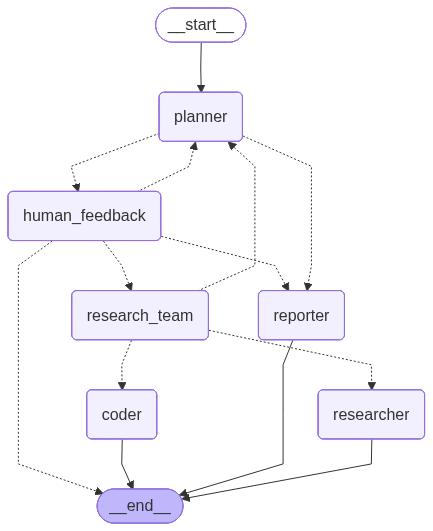

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from pprint import pprint

# Define the initial input for the workflow
initial_input = State(
    messages=[HumanMessage(content="Develop a 3-month marketing plan for a new AI-powered gardening app.")],
    plan_iterations=0
)

# Define the configuration for this run
# Ensure your environment variables for the LLM are set correctly
runnable_config = RunnableConfig(
    configurable={"max_plan_iterations": 2}
)

# --- Invoke the workflow ---
print("🚀 Invoking the agent workflow...")
final_state = app.invoke(initial_input, config=runnable_config)
print("\n" + "="*50)
print("✅ Workflow finished. Final State:")
print("="*50)

# Pretty-print the final state for inspection
pprint(final_state)

2025-10-08 13:20:51,913 - INFO - Planner generating full plan
2025-10-08 13:20:51,914 - INFO - Building plan with TrustCall
2025-10-08 13:20:51,962 - WARNING - Key '$defs' is not supported in schema, ignoring
2025-10-08 13:20:51,963 - WARNING - Key 'examples' is not supported in schema, ignoring


🚀 Invoking the agent workflow...


2025-10-08 13:20:59,601 - INFO - Successfully generated and validated a new plan.
2025-10-08 13:20:59,601 - INFO - Planner requires additional information. Routing for human feedback.



✅ Workflow finished. Final State:
{'__interrupt__': [Interrupt(value='Please Review the Plan.',
                             id='61f573ae1d515d20b0c3d328b471a333')],
 'current_plan': Plan(locale='en-US', has_enough_context=False, thought='To develop a comprehensive 3-month marketing plan for a new AI-powered gardening app, I need to gather extensive information across several key areas. This includes understanding the target audience, analyzing the competitive landscape, identifying effective marketing channels, and establishing performance metrics and budget considerations. Since no context about the app or its target market is provided, I must initiate a series of research steps to collect this crucial data.', title='3-Month Marketing Plan for an AI-Powered Gardening App', steps=[Step(need_search=True, title='Market Research and Target Audience Analysis for AI Gardening Apps', description='Collect comprehensive data on the current gardening app market, including market size, growth 

In [ ]:
print(final_state['current_plan'])

locale='en-US' has_enough_context=False thought='To develop a comprehensive 3-month marketing plan for a new AI-powered gardening app, it is essential to gather detailed information on the target market, competitive landscape, effective marketing channels, content strategies, and key performance indicators. The current context lacks this crucial information, necessitating a focused research effort to ensure the marketing plan is robust and data-driven.' title='3-Month Marketing Plan for an AI-Powered Gardening App' steps=[Step(need_search=True, title='Market, Audience, and Competitor Analysis for AI Gardening Apps', description='Gather comprehensive data on the target audience for AI-powered gardening apps, including demographics, psychographics, gardening habits, tech adoption rates, and pain points. Research the current market size, growth trends, and identify key competitors in the gardening and AI app space. Analyze their marketing strategies, app features, pricing models, user rev

In [ ]:
final_state["__interrupt__"][0].id

'61f573ae1d515d20b0c3d328b471a333'